# **Анализ пользовательского поведения в мобильном приложении**


**Описание проекта**

В нашем распоояжения данные от стартапа, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи их мобильного приложения.

Задачи:
1. Изучить воронку продаж (Узнать, как пользователи доходят до покупки, Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?).
2. Исследовать результаты A/A/B-эксперимента, по смене шрифта во всём приложении.
Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выяснить, какой шрифт лучше.


In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy import stats as st
import math as mth
from plotly import graph_objects as go

In [2]:
try:
  logs = pd.read_csv('logs_exp.csv', sep='\t')
except:
  logs = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')


##  **Изучение общей информации из имеющихся данных**

In [3]:
display(logs.head(5))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


##  **Подготовка данных для анализа**

Приведёние названия столбцов к нижнему регистру и хорошему стилю

In [5]:
logs.rename(columns = {'EventName':'event', 'DeviceIDHash':'user', 'EventTimestamp': 'timestamp', 'ExpId': 'group'}, inplace = True)

#display(logs.head(5))

Преобразуем столбец timestamp в формат даты и времени и создатим ещё дин столбец отдельно с датой события.

In [6]:
logs['timestamp'] = pd.to_datetime(logs['timestamp'], unit = 's')
logs['date'] = logs['timestamp'].dt.date
logs['date'] = logs['date'].astype('datetime64')
display(logs.head(5))

,event,user,timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [7]:
#logs.info()

Теперь все форматы соответствуют данным в датафрейме.

Просмотрим названия событий, представленных в данных и оценим их количество.

In [8]:
logs['event'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event, dtype: int64

Проверка данных на явные дубликаты

In [9]:
print('Количество дубликатов:', logs.duplicated().sum())

Количество дубликатов: 413


Проверка на дубликаты выявила 413 дубликатов. Почистим данные от них.

In [10]:
logs = logs.drop_duplicates().reset_index(drop=True)
#logs.info()

In [11]:
logs.isna().sum()

event        0
user         0
timestamp    0
group        0
date         0
dtype: int64

Пропуски в данных отсутствуют

Проверим значения в столбце event_date на наличие аномалий и за одно, сгруппировав данные, посмотрим период за который у нас представлены данные.

In [12]:
logs.groupby('group').agg(
    min_date = ('date', 'min'),
    max_date = ('date', 'max')
)

,min_date,max_date
group,,
246,2019-07-25,2019-08-07
247,2019-07-25,2019-08-07
248,2019-07-25,2019-08-07


Аномальные значения отсутствуют, как и указано в ТЗ в данных присутствуют только эксперименты 246 и 247 (контрольные группы) и 248 (экспериментальная).
Данные по всем группам представлены в одном и том же временном периоде - с 25.07.2019 по 07.08.2019

### ***Вывод по разделу Изучение общей информации из имеющихся данных***

1. Данные в файле представлены за период с 25.07.2019 по 07.08.2019.
2. Названия столбцов переименованы в более удобные и приведены к хорошему стилю.
3. Произведена смена типов данных в столбце о дате и времени, добавлен дополнительный столбец содержащий только дату события.
4. Выявлены 413 дубликатов, данные очищены от них.

Работа по предобработке данных завершена, данные подготовлены к дальнейшему анализу.

## **Изучение и проверка данных**


Просмотрим сколько событий в логе и посчитаем количество каждого события.

In [13]:
logs['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

In [14]:
event_counts = logs['event'].value_counts().sum()
print('Всего событий в логе:',  event_counts)

Всего событий в логе: 243713


Так же посмотрим сколько всего пользователей в логе.

In [15]:
user_counts = logs['user'].nunique()
print('Количество пользователей в логе:', user_counts)

Количество пользователей в логе: 7551


Оценим сколько в среднем событий приходится на пользователя.

In [16]:
print('Среднее число событий на пользователя:', (logs.groupby('user')['event'].agg('count').mean()).round(2))

Среднее число событий на пользователя: 32.28


Ранее мы определили период за который присутствуют даные в файле, это:

min дата - 25.07.2019

max дата - 07.08.2019

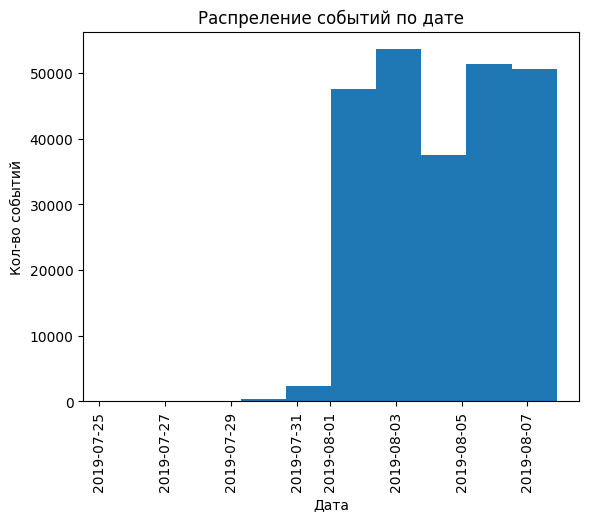

In [17]:

plt.hist(logs['timestamp'])
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.title('Распреление событий по дате')
plt.show ()

Из гистограммы виден перекос по данным. Основная часть данных присутствует за период с 01.08.2019 по 07.08.2019.
Таким образом данные полные только за этот период, всё что ранее 01.08.2019г решено отбросить.

In [18]:
logs=logs.query('date >= "2019-08-01"')
#display(logs_1.head(10))


In [19]:

event_counts_new = logs['event'].value_counts().sum()
print('Всего событий в логе:',  event_counts_new)

user_counts_new = logs['user'].nunique()
print('Количество пользователей в логе:', user_counts_new)

Всего событий в логе: 240887
Количество пользователей в логе: 7534


Обновим расчет среднего числа событий на пользователя по обновленным данным.

In [20]:
print('Среднее число событий на пользователя:', (logs.groupby('user')['event'].agg('count').mean()).round(2))

Среднее число событий на пользователя: 31.97


Посмотрим, много ли событий и пользователей мы потеряли, отбросив старые данные.

In [21]:
data = {'name': ['event_counts', 'user_counts'], 'before': [event_counts, user_counts ], 'after': [event_counts_new, user_counts_new]}
df = pd.DataFrame(data)
df['difference']= df['before']-df['after']
df['share']=(df['difference']/df['before']).transform(lambda x: '{:,.2%}'.format(x))

display(df)


,name,before,after,difference,share
0,event_counts,243713,240887,2826,1.16%
1,user_counts,7551,7534,17,0.23%


По данным можно увидеть, что мы потеряли совсем не значительный объем данных, в событиях это 1.16%, в пользователях это 0.23%

Проверим, что у нас остались пользователи из всех трёх экспериментальных групп.


In [22]:
logs.groupby('group')['user'].nunique()

group
246    2484
247    2513
248    2537
Name: user, dtype: int64

Всё на месте.

Убедимся что все пользоатели в группах не пересекаются, пользователь попавший в одну из групп остаётся в этой группе до конца теста.

In [23]:
# выделили клиентов, попавших более чем в одну группу
user_duplicates = logs.groupby('user').agg({'group' : 'nunique'}).reset_index().query('group>1')['user']
print('Количество пересекающихся пользователей :', user_duplicates.count())

Количество пересекающихся пользователей : 0


### ***Вывод по разделу Изучение и проверка данных***

1. Не за весь период в логе присутсвовали одинаково полные данные, решено отбросить часть данных, что бы не было перекоса. Отброшенные данные составили около 1%.
В итоге теперь мы располагаем данными за период с 01.08.2019 по 07.08.2019г.
2. После очищения данных:
 - количество событий в логе - 240887;
 - количество пользователей - 7534;
 - среднее количество событий на пользователя 31.97
3. Пользователи, присутсвующие сразу в нескольких экпериментальных группах не выявлены.


## **Изучение воронки событий**

Посмотрим, какие события есть в логах и как часто они встречаются.


In [24]:
logs['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64


MainScreenAppear - Появление главного экрана

OffersScreenAppear - Появление экрана предложений

CartScreenAppear - Появление экрана корзины

PaymentScreenSuccessful - Появление экрана Успешный платёж

Tutorial - Руководство пользователя

Посчитаем, сколько пользователей совершали каждое из этих событий.

А так же посчитаем долю пользователей, которые хоть раз совершали событие, конверсию и конверсию в шаг.

Оценим долю пользователей которые доходят от первого события до оплаты.


In [25]:
events_users = logs.groupby('event').agg({'user':'nunique'}).sort_values(by='user', ascending=False)
events_users.columns = ['users']
events_users = events_users.reset_index()
events_users['conversion'] = (events_users['users'] / logs['user'].nunique()).transform(lambda x: '{:,.2%}'.format(x))
events_users['conversion_per_step']= (events_users['users']/(events_users['users'].shift(1))).transform(lambda x: '{:,.2%}'.format(x))
events_users

,event,users,conversion,conversion_per_step
0,MainScreenAppear,7419,98.47%,nan%
1,OffersScreenAppear,4593,60.96%,61.91%
2,CartScreenAppear,3734,49.56%,81.30%
3,PaymentScreenSuccessful,3539,46.97%,94.78%
4,Tutorial,840,11.15%,23.74%


По данным сводной таблицы можно заметить, что событие Tutorial имеет очень маленькую конверсию, и по логике к нему могут обратиться на любом из этапов при необходимости, но делают это редко. Поэтому оно не является частью воронки.

Для лучшего восприятия посмотрим визуальный график нашей воронки, предварительно исключив из неё событие Tutorial.

In [26]:
events_users=events_users.query('event != "Tutorial"')
events_users

,event,users,conversion,conversion_per_step
0,MainScreenAppear,7419,98.47%,nan%
1,OffersScreenAppear,4593,60.96%,61.91%
2,CartScreenAppear,3734,49.56%,81.30%
3,PaymentScreenSuccessful,3539,46.97%,94.78%


In [27]:
fig = go.Figure(go.Funnel(
    x = events_users['users'],
    y = events_users['event']))
fig.update_layout(title_text='Процент пользователей перешедших на следующий этап относительно первого этапа воронки')
fig.show()


### ***Выводы по разделу Изучение воронки событий***

1. 7419 пользователей заходили на главный экран мобильного приложения. Доля пользователей, которые хоть раз совершили событие составила 37,51%.
При этом можно заметить, что не все уникальные пользователи первым шагом попадали на главный экран.

2. Предположительно события происходят в следующем порятке:

- MainScreenAppear - Появление главного экрана

- OffersScreenAppear - Появление экрана предложений

- CartScreenAppear - Появление экрана корзины

- PaymentScreenSuccessful - Появление экрана Успешный платёж

А вот событие Tutorial (Руководство пользователя) имеет очень маленькую конверсию, и по логике к мену могу обратиться на любом из этапов при необходимости, но делают это редко. Поэтому оно не является частью воронки.


3. До совершения оплаты покупки, доля пользователей проходящих на следующий шаг воронки самая высокая при переходе с шага CartScreenAppear (Появление экрана корзины) на шаг PaymentScreenSuccessful (Появление экрана Успешный платёж), почти 95%. А вот при переходе с главного экрана на экран предложений она составляет чуть менее 62%.

4. Больше всего пользователей теряется на втором шаге при переходе от главного экрана на экран предложений, доля потерь составляет 37.51% от первоначального объема.

5. Доля пользователей доходящих от первого события до оплаты составляет 46,97%, это очень хороший показатель.



## **Изучение результатов эксперимента**

Ещё раз посмотрим сколько пользователей в каждой экспериментальной группе

In [28]:
logs=logs.query('event != "Tutorial"')

user_group=logs.groupby('group')['user'].nunique().reset_index()
display(user_group)

,group,user
0,246,2483
1,247,2512
2,248,2535


246 и 247 это наши контрольные группы  для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов.
Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Первым критерии успешного A/A-теста является различие количество пользователей в различных группах не более, чем на 1%, проверим это.

In [29]:
user_group=logs.groupby('group')['user'].nunique().reset_index()
user_group['all_user']=user_group['user'].sum()
user_group['share']=(user_group['user']/user_group['all_user']).transform(lambda x: '{:,.2%}'.format(x))
display(user_group)

,group,user,all_user,share
0,246,2483,7530,32.97%
1,247,2512,7530,33.36%
2,248,2535,7530,33.67%


Как видим из рассчета количество пользователей между группами 246 и 247 менее 1%.


Следующий критерий это - Попавший в одну из групп посетитель остаётся в этой группе до конца теста.
Мы уже делали данную проверку в раздели Изучение и проверка данных и убедились что все пользоатели в группах не пересекаются.


Так же для всех групп фиксировались и отправлялись в системы аналитики данные об одном и том же.



**5.1.** Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

Для проведения дальнейшего анализа создадим сводную таблицу с необходимыми столбцами.

In [30]:
test = logs.pivot_table(index='event', columns='group', values='user', aggfunc='nunique').reset_index().sort_values(246, ascending=False).reset_index(drop=True)

In [31]:
t_user=logs.groupby('group')['user'].nunique().reset_index()

In [32]:
test['all_246']= t_user.loc[0, 'user']
test['all_247']= t_user.loc[1, 'user']
test['all_248']= t_user.loc[2, 'user']
test['conv_246'] = (test[246] / test['all_246']).transform(lambda x: '{:,.2%}'.format(x))
test['conv_246_per_step']= (test[246]/(test[246].shift(1))).transform(lambda x: '{:,.2%}'.format(x))
test['conv_247'] = (test[247] / test['all_247']).transform(lambda x: '{:,.2%}'.format(x))
test['conv_247_per_step']= (test[247]/(test[247].shift(1))).transform(lambda x: '{:,.2%}'.format(x))
test['conv_248'] = (test[248] / test['all_248']).transform(lambda x: '{:,.2%}'.format(x))
test['conv_248_per_step']= (test[248]/(test[248].shift(1))).transform(lambda x: '{:,.2%}'.format(x))
test = test[['event', 246, 247, 248, 'conv_246', 'conv_247', 'conv_248', 'conv_246_per_step', 'conv_247_per_step', 'conv_248_per_step', 'all_246', 'all_247', 'all_248']]
test

group,event,246,247,248,conv_246,conv_247,conv_248,conv_246_per_step,conv_247_per_step,conv_248_per_step,all_246,all_247,all_248
0,MainScreenAppear,2450,2476,2493,98.67%,98.57%,98.34%,nan%,nan%,nan%,2483,2512,2535
1,OffersScreenAppear,1542,1520,1531,62.10%,60.51%,60.39%,62.94%,61.39%,61.41%,2483,2512,2535
2,CartScreenAppear,1266,1238,1230,50.99%,49.28%,48.52%,82.10%,81.45%,80.34%,2483,2512,2535
3,PaymentScreenSuccessful,1200,1158,1181,48.33%,46.10%,46.59%,94.79%,93.54%,96.02%,2483,2512,2535


Самое популярное событие это MainScreenAppear.

***Число пользователей совершивших данное событие в контрольных группах:***

группа 246 - 2450 пользователей

группа 247 - 2476 пользователей

***Доля пользователей совершивших событие:***

группа 246 - 98.67%

группа 247 - 98.57%


Проверим, будет ли отличие между группами статистически достоверным.

***Сформулируем гипотезы***

H0: различий в долях групп 246 и 247 нет.

H1: между долями есть значимая разница.

In [33]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([test.loc[0,246], test.loc[0,247]])
nobs = np.array([test.loc[0,'all_246'], test.loc[0,'all_247']])
alpha = 0.05  # критический уровень статистической значимости
stat, p_value = proportions_ztest(count, nobs)

print ('Событие', test.loc[0, 'event'])
print('p_value: ', '{0:0.3f}'.format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )


Событие MainScreenAppear
p_value:  0.753
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Согласно проведенном тесту, различие между контрольными группа 246 и 247 при событии MainScreenAppear статистически незначимо.

Проделаем то же самое тестирование для всех других событий, для этого обернём тест в функцию.

In [34]:
from statsmodels.stats.proportion import proportions_ztest
def z_test(alpha, event, group1, group2, total_group1, total_group2):
  count = np.array([test.loc[test['event']== event, group1], test.loc[test['event']== event,group2]])
  nobs = np.array([test.loc[test['event']== event, total_group1], test.loc[test['event']== event, total_group2]])
  #alpha = 0.05  # критический уровень статистической значимости
  stat, p_value = proportions_ztest(count, nobs)

  print ('Результаты теста для групп', group1, 'и', group2)
  print ('Событие', event)
  print ('p_value: ', p_value.round(3))


  if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
  else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')



In [35]:
# выделим события в отдельный список
event_names = list(test['event'])
event_names

['MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful']

In [36]:
#проверим, будет ли отличие между группами статистически достоверным.
for event in event_names:
  z_test(0.05, event, 246, 247, 'all_246', 'all_247')
  print( )


Результаты теста для групп 246 и 247
Событие MainScreenAppear
p_value:  [0.753]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 247
Событие OffersScreenAppear
p_value:  [0.248]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 247
Событие CartScreenAppear
p_value:  [0.229]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 247
Событие PaymentScreenSuccessful
p_value:  [0.114]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Согласно проведенным тестам по всем событиям, различие между контрольными группа 246 и 247 статистически незначимо, поэтому можно сказать, что разбиение на группы работает корректно.

Аналогичные тестирования проведем с группой с изменённым шрифтом.

**5.2.** Сравните результаты с каждой из контрольных групп в отдельности по каждому событию.



***Сформулируем гипотезы***

H0: различий в долях групп 246 и 248 нет.

H1: между долями есть значимая разница.

In [37]:
for event in event_names:
  z_test(0.05, event, 246, 248, 'all_246', 'all_248')
  print( )

Результаты теста для групп 246 и 248
Событие MainScreenAppear
p_value:  [0.339]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 248
Событие OffersScreenAppear
p_value:  [0.214]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 248
Событие CartScreenAppear
p_value:  [0.081]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246 и 248
Событие PaymentScreenSuccessful
p_value:  [0.217]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



***Сформулируем гипотезы***

H0: различий в долях групп 247 и 248 нет.

H1: между долями есть значимая разница.

In [38]:
for event in event_names:
  z_test(0.05, event, 247, 248, 'all_247', 'all_248')
  print( )

Результаты теста для групп 247 и 248
Событие MainScreenAppear
p_value:  [0.519]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 247 и 248
Событие OffersScreenAppear
p_value:  [0.933]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 247 и 248
Событие CartScreenAppear
p_value:  [0.588]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 247 и 248
Событие PaymentScreenSuccessful
p_value:  [0.728]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Для того что бы провести тест по объединенной контрольной группе нужно немного доработать сводную таблицу с данными.

In [39]:
test['246+247']= test[246]+test[247]
test['all_246_247']= test['all_246']+test['all_247']
test

group,event,246,247,248,conv_246,conv_247,conv_248,conv_246_per_step,conv_247_per_step,conv_248_per_step,all_246,all_247,all_248,246+247,all_246_247
0,MainScreenAppear,2450,2476,2493,98.67%,98.57%,98.34%,nan%,nan%,nan%,2483,2512,2535,4926,4995
1,OffersScreenAppear,1542,1520,1531,62.10%,60.51%,60.39%,62.94%,61.39%,61.41%,2483,2512,2535,3062,4995
2,CartScreenAppear,1266,1238,1230,50.99%,49.28%,48.52%,82.10%,81.45%,80.34%,2483,2512,2535,2504,4995
3,PaymentScreenSuccessful,1200,1158,1181,48.33%,46.10%,46.59%,94.79%,93.54%,96.02%,2483,2512,2535,2358,4995


***Сформулируем гипотезы***

H0: различий в долях между объединенныной контрольной группой 246 и 247 и экспериментальной 248 нет.

H1: между долями есть значимая разница.


In [40]:
for event in event_names:
  z_test(0.05, event, '246+247', 248, 'all_246_247', 'all_248')
  print( )

Результаты теста для групп 246+247 и 248
Событие MainScreenAppear
p_value:  [0.349]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246+247 и 248
Событие OffersScreenAppear
p_value:  [0.446]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246+247 и 248
Событие CartScreenAppear
p_value:  [0.187]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп 246+247 и 248
Событие PaymentScreenSuccessful
p_value:  [0.611]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Изначально для проверки статистических гипотез был выбран уровень значисости 0.05.
Но с учетом того, что у нас проводились множественные проверки, для снижения вероятности ложнопозитивного результа нужно применить метод корректировки уровня значимости, например Бонферрони, поделя уровень значимости на число проверок гипотез. В нашем случае было 16 проверок, и скорректированный уровень значимости равен 0,0031.
При этом нужно помнить, что боясь совершить ошибку первого рода и уменьшая уровень значимости мы рискуем множество успешных экспериментов признать не успешными.

С учетов того, что ни в одном из проведенных тестов уровень p-value не опускался ниже 0.081 принято решение не проводить повторно проверку гипотез со скорректированным уровнем значимости, т.к. это в нашем случае не повлияет на результат.



### **Выводы по разделу Изучение результатов эксперимента**
Согласно всем проведенным тестам различия между контрольными группами 246 и 247 и экспериментальной 248 являются статистически незначимыми.
Таким образом можно сказать, изменение шрифтов не повлияло на взаимодействие пользователей с приложением. Пользователи переходят от события к событию в тех же долях, как и до изменения шрифта в приложении.

## **Выводы по проделанной работе**

Была проведена аналитическая работа по данным стартапа, который продаёт продукты питания. Было необходимо разобраться как ведут себя пользователи их мобильного приложения.

На начальном этапе выполнена предобработка данных, после чего была изучена воронка продаж и получены следующеи выводы:

1. Пользователи доходят до покупки в 4 этапа:
- MainScreenAppear - Появление главного экрана
- OffersScreenAppear - Появление экрана предложений
- CartScreenAppear - Появление экрана корзины
- PaymentScreenSuccessful - Появление экрана Успешный платёж

А вот событие Tutorial (Руководство пользователя) имеет очень маленькую конверсию, и по логике к мену могу обратиться на любом из этапов при необходимости, но делают это редко. Поэтому оно не является частью воронки.

2. 7419 пользователей заходили на главный экран мобильного приложения. Доля пользователей, которые хоть раз совершили событие составила 37,51%.

3. До совершения оплаты покупки, доля пользователей проходящих на следующий шаг воронки самая высокая при переходе с шага CartScreenAppear (Появление экрана корзины) на шаг PaymentScreenSuccessful (Появление экрана Успешный платёж), почти 95%. А вот при переходе с главного экрана на экран предложений она составляет чуть менее 62%.

4. Больше всего пользователей теряется на втором шаге при переходе от главного экрана на экран предложений, доля потерь составляет 37.51% от первоначального объема.

5. Доля пользователей доходящих от первого события до оплаты составляет 46,97% (3539 пользователей).

Далее были исследованы результаты A/A/B-эксперимента, проведены тесты о различии статистических критериев между контрольными и экспериментальной группами.

Согласно всем проведенным тестам различия между контрольными группами 246 и 247 и экспериментальной 248 являются статистически незначимыми. Таким образом можно сказать, изменение шрифтов не повлияло на взаимодействие пользователей с приложением. Пользователи переходят от события к событию в тех же долях, как и до изменения шрифта в приложении.

